In [ ]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install wordcloud
!pip install sklearn
!pip install text_preprocessing

In [2]:
# Step 0. Load libraries and custom modules
# Dataframes and matrices ----------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
plt.style.use('tableau-colorblind10')
# Mathematical functions -----------------------------------------------
from scipy.stats import norm
# Text processors ------------------------------------------------------
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
# Preprocessing --------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Text modeling --------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Model creating -------------------------------------------------------
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
# Metrics --------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
# Custom functions -----------------------------------------------------
from text_preprocessing import clean_stopwords 

In [4]:
# We'll use a collection of sentiments for text analysis as a dataset
# This dataset was published in Saif M. Mohammad and Peter Turney. (2013), 
# ``Crowdsourcing a Word-Emotion Association Lexicon.'' 
# Computational Intelligence, 29(3): 436-465.
# It's only for research and educational purposes.
# URL: http://saifmohammad.com/WebPages/lexicons.html  
nrc = pd.read_csv('../data/raw/NRC.csv', names=['word','sentiment','polarity'])
nrc = nrc.query('polarity == 1')

In [6]:
# Step 1. Load the data
# Data extracted from https://www.thetrumparchive.com
# Data case: During the 2016 US presidential election, the candidate 
# Donald Trump used twitter to communicate with potential voters. 
# The campaign was during 2015-06-17 and 2016-11-08
# We'll try to analyze these campaign tweets from iPhone and Android
# Data description
# source -> device of origin
# id_str -> unique identifier
# text -> tweet text content
# created_at -> Date of creation, not including timezone
# retweet_count -> Count of retweets (difusion)
# in_reply_to_usr_id_str -> If it's a reply, grab the user id
# favourite_count -> Count of users that liked the tweet
# is_retweet -> If the post is a retweet  
# 1.1 Open data and get a glimpse
df_raw = pd.read_csv('../data/raw/trump_tweets.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20761 entries, 0 to 20760
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   source                   20761 non-null  object 
 1   id_str                   20761 non-null  int64  
 2   text                     20761 non-null  object 
 3   created_at               20761 non-null  object 
 4   retweet_count            20761 non-null  int64  
 5   in_reply_to_user_id_str  2442 non-null   float64
 6   favorite_count           20761 non-null  int64  
 7   is_retweet               20761 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 1.1+ MB


In [7]:
# 1.1 Sample some observations
df_raw.sample(10)

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
18362,Twitter for Android,688333063093374976,The Ted Cruz wiseguy apology to the people of ...,2016-01-16T12:12:45Z,2348,NaN,5856,False
9457,Twitter Web Client,290909948056051713,Can you imagine if Obama had to give today's p...,2013-01-14T19:55:11Z,139,NaN,49,False
9107,Twitter Web Client,296704862203297792,.@yankees are privately ecstatic over A-Rod's ...,2013-01-30T19:42:06Z,52,NaN,14,False
659,TweetDeck,111493251340566528,Why was @BarackObama selling guns to Mexican d...,2011-09-07T17:37:17Z,561,NaN,280,False
5758,Twitter for Android,364572183462297600,@MdsdadDotson Thanks Michelle!,2013-08-06T02:22:36Z,0,4.552625e+08,1,False
8611,Twitter Web Client,302421568326336512,@sfyfe_n Thanks Neil.,2013-02-15T14:18:15Z,0,1.084427e+09,0,False
6095,Twitter for Android,355832475487961090,@JTFoxx True and thanks!,2013-07-12T23:34:07Z,2,3.312671e+07,0,False
8135,Twitter for Android,308600274249981953,@foyt4timewinner. Thanks!,2013-03-04T15:30:13Z,2,7.547599e+07,0,False
11301,Twitter for Android,471991556850081792,Have you ever seen our country look weaker or ...,2014-05-29T12:28:50Z,482,NaN,439,False
16788,Instagram,745298514096308225,Obama-Clinton inherited $10T in debt and turne...,2016-06-21T16:53:07Z,6477,NaN,15008,False


In [8]:
# Step 2. Transform and wrangle the data
# 2.1 Make a copy
df_interim = df_raw.copy()

In [9]:
# 2.2 Get rid of uninformative columns
df_interim = df_interim.drop(['id_str','is_retweet','in_reply_to_user_id_str'], axis=1)

In [10]:
# 2.3 Convert columns to the right format
df_interim['created_at'] = df_interim['created_at'].astype('datetime64')
df_interim['source'] = pd.Categorical(df_interim['source'])

In [11]:
# 2.4 Filter dates for analysis
df_interim = df_interim.loc[(df_interim['created_at'] >= '2015-06-17') \
    & (df_interim['created_at'] <= '2016-11-08')]

In [16]:
# 2.5 Consider time is UTC, convert to EST
df_interim.to_csv('../data/interim/trump_tweets.csv', index=False)
df = df_interim.copy()

In [17]:
# 2.5 Filter source for analysis
df_interim = df_interim.loc[(df_interim['source'].str.contains('iPhone')) \
    | (df_interim['source'].str.contains('Android'))]
df_interim['source'] = df_interim['source'].cat.remove_unused_categories()

In [18]:
# 2.5 Save and create a copy for analysis
df_interim.to_csv('../data/interim/trump_tweets.csv', index=False)
df = df_interim.copy()

In [19]:
# Step 3. Perform EDA
# 3.1 Get basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 12072 to 18506
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   source          3946 non-null   category      
 1   text            3946 non-null   object        
 2   created_at      3946 non-null   datetime64[ns]
 3   retweet_count   3946 non-null   int64         
 4   favorite_count  3946 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(2), object(1)
memory usage: 158.0+ KB


In [20]:
# 3.2 Get a sample
df.sample(10)

,source,text,created_at,retweet_count,favorite_count
18251,Twitter for Android,It's time for Ted Cruz to either settle his pr...,2016-01-25 13:26:21,2819,7635
16357,Twitter for Android,Thank you to all of the television viewers tha...,2016-07-30 23:00:07,11054,45087
16255,Twitter for Android,"Michael Morell, the lightweight former Acting ...",2016-08-07 23:09:08,7653,24140
12091,Twitter for Android,.@CharlesHurt You were great on @seanhannity...,2015-12-30 12:31:59,699,2555
15617,Twitter for iPhone,I will Make Our Government Honest Again -- bel...,2016-10-18 15:33:18,13622,27985
18265,Twitter for iPhone,"Just left Sioux Center, Iowa. My speech was ve...",2016-01-23 20:14:05,1116,4041
17909,Twitter for iPhone,WOW! Thank you Massachusetts! See you soon. #V...,2016-02-23 01:29:26,2118,6224
12836,Twitter for iPhone,Expecting a great crowd of amazing people. Que...,2015-10-24 19:41:08,754,1908
15711,Twitter for iPhone,CNN is the worst - fortunately they have bad r...,2016-10-10 19:14:00,14451,34322
17453,Twitter for iPhone,Trump defends campaign manager charged for bru...,2016-03-29 21:19:56,3389,10707


In [21]:
# 3.3 Describe numerical and datetime data
df.describe(datetime_is_numeric=True)

,created_at,retweet_count,favorite_count
count,3946,3946.000000,3946.000000
mean,2016-03-31 12:49:53.323872256,5839.465281,15666.982767
min,2015-06-20 01:03:05,61.000000,167.000000
25%,2015-12-20 23:19:10.500000,2013.250000,5350.000000
50%,2016-03-16 10:29:30.500000,4162.500000,11981.500000
75%,2016-07-25 14:04:26.500000,7807.250000,21527.000000
max,2016-11-07 22:21:53,168765.000000,297281.000000
std,NaN,6156.818896,14650.408743


In [22]:
# 3.4 Describe categorical data
df['source'].value_counts()

Twitter for iPhone     2099
Twitter for Android    1847
Name: source, dtype: int64

In [ ]:
# 3.5 Get histograms for numerical data

In [23]:
# 3.6 Make a plot of tweets frequence rate by source
df_plot = (df
            .assign(hour=df["created_at"].dt.hour)
            .groupby(["source", "hour"])
            .agg(count=("source", "count"))
            .assign(rate=lambda df: df["count"]/df.groupby("source")["count"].sum())
            .reset_index())
df_plot

,source,hour,count,rate
0,Twitter for Android,0,89,0.048186
1,Twitter for Android,1,90,0.048728
2,Twitter for Android,2,93,0.050352
3,Twitter for Android,3,78,0.042231
4,Twitter for Android,4,49,0.026530
5,Twitter for Android,5,22,0.011911
6,Twitter for Android,6,2,0.001083
7,Twitter for Android,7,6,0.003249
8,Twitter for Android,8,1,0.000541
9,Twitter for Android,9,28,0.015160


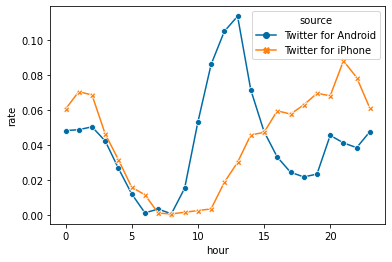

In [24]:
sns.lineplot(data=df_plot, x="hour", y="rate", hue="source", markers=True, style="source", dashes=False)
plt.show()

In [ ]:
# 3.7 Get a glimpse of the most retweeted tweets

In [ ]:
# 3.8 Get a glimpse of the most liked tweets

In [ ]:
# 3.9 Let's get a glimpse of common words in the tweets' text

In [ ]:
# 3.10 Process text to extract stopwords

In [ ]:
# 3.11 Extract urls
url_pat = 'https://t.co/[A-Za-z\d]+|&amp;'


In [ ]:
# 3.12 Extract special characters


In [ ]:
# 3.13 Extract numbers


In [ ]:
# 3.14 See the results


In [ ]:
# 3.15 Let's see a wordcloud
